In [1]:
#imports
import scipy
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import butter, filtfilt


In [2]:
# Basic Function defintions:

def time_to_sec(time):
    
    #input: time array in ms starting at any point
    #returns: time array in second and starting at 0
    
    time_size = time.size
    og_time = time[0]
    new_time = [0]*time_size

    for i in range(0,time_size):
        new_time[i] = (time[i]-og_time)/1000
        
    return new_time


def rename_columns(dataframe,new_names):
    
    #input: the dataframe and the list of new names for the columns
    #output: the same dataframe with the new column names
    
    new_frame = dataframe
    
    old_names = dataframe.columns
    
    for n in range(0,len(old_names)):
        new_frame.rename(columns={old_names[n]: new_names[n]}, inplace=True)
        
    return new_frame


def plot_IMU(IMU_dataframe):
    
    #input: IMU dataframe with adapted column names
    #return: plots the data
    
    IMU_time = IMU_dataframe.time
    ylabels = IMU_dataframe.columns
    
    fig, axs = plt.subplots(6,figsize=(16,12))
    axs[0].plot(IMU_time,IMU_dataframe.x_acc)
    axs[1].plot(IMU_time,IMU_dataframe.y_acc)
    axs[2].plot(IMU_time,IMU_dataframe.z_acc)
    axs[3].plot(IMU_time,IMU_dataframe.x_rot)
    axs[4].plot(IMU_time,IMU_dataframe.y_rot)
    axs[5].plot(IMU_time,IMU_dataframe.z_rot)
    
    for k in range(0,6):
        axs[k].set_ylabel(ylabels[k+1])
        axs[k].grid()
    
    plt.show()
    
    
def plot_EMG(EMG_dataframe):
    
    #input: EMG dataframe with adapted column names
    #return: plots the data
    
    EMG_time = EMG_dataframe.time
    ylabels = EMG_dataframe.columns
    
    fig, axs = plt.subplots(4,figsize=(16,8))
    axs[0].plot(EMG_time,EMG_dataframe.ch1)
    axs[1].plot(EMG_time,EMG_dataframe.ch2)
    axs[2].plot(EMG_time,EMG_dataframe.ch3)
    axs[3].plot(EMG_time,EMG_dataframe.ch4)
    
    for k in range(0,4):
        axs[k].set_ylabel(ylabels[k+1])
        axs[k].grid()

    plt.show()
    
def IMU_reader(IMU_csv):
    
    #input: raw IMU .csv data as received from shimmers3 IMU sensor
    #return: IMU data ready for next steps

    IMU_columns = ['time', 'x_acc', 'y_acc', 'z_acc', 'x_rot', 'y_rot', 'z_rot','NaN']
    
    IMU_data = pd.read_csv(IMU_csv,skiprows=[0,1])
    
    new_IMU = rename_columns(IMU_data,IMU_columns)
    
    #set the time in sec and starting at 0:
    t_in_s = time_to_sec(new_IMU.time)
    
    for t in range(0,len(new_IMU.time)):
        new_IMU.time[t] = t_in_s[t]
    
    return(new_IMU)
    
    
def EMG_reader(EMG_csv):
    
    #input: raw EMG .csv data as received from shimmers3 IMU sensor
    #return: EMG data ready for next steps

    EMG_columns = ['time', 'CAL1', 'CAL2', 'ch1', 'ch2', 'ch3', 'ch4', 'NaN'] 
    
    EMG_data = pd.read_csv(EMG_csv,skiprows=[0,1])
    
    new_EMG = rename_columns(EMG_data,EMG_columns)
    
    #set the time in sec and starting at 0:
    t_in_s = time_to_sec(new_EMG.time)
    
    for t in range(0,len(new_EMG.time)):
        new_EMG.time[t] = t_in_s[t]
    
    return(new_EMG)
    
    
def IMU_inter(IMU,fs):
    
    #input: IMU and wished fs
    #returns: IMU with wished fs (t in sec)

    time = IMU.time
    
    f_og = 1/(time[51]-time[50])

    k = round(fs/f_og)

    
    ms_time = np.linspace(0,round(max(time)*1000000),len(time)*k)
    new_time = []
    
    for t in ms_time:
        new_time.append(t/1000000)
    
    col = ['time', 'x_acc', 'y_acc', 'z_acc', 'x_rot', 'y_rot', 'z_rot']
    
    new_x = np.interp(new_time,time,IMU.x_acc)
    new_y = np.interp(new_time,time,IMU.y_acc)
    new_z = np.interp(new_time,time,IMU.z_acc)
    
    new_phi = np.interp(new_time,time,IMU.x_rot)
    new_theta = np.interp(new_time,time,IMU.y_rot)
    new_psi = np.interp(new_time,time,IMU.z_rot)
    
    data = {'time':new_time, 'x_acc':new_x, 'y_acc':new_y, 'z_acc':new_z, 'x_rot':new_phi, 'y_rot':new_theta, 'z_rot':new_psi}
    
    new_frame = pd.DataFrame(data)
    
    return new_frame

In [3]:
# Import function:

def import_data(s_nbr,m_nbr,side):
    
    #input: subject nbr, motion nbr, side(r or l)
    #returns: corresponding EMG and IMU files

    EMG_dir = "data/s" + str(s_nbr) + "_m" + str(m_nbr) + "_" + side + "/emg_s" + str(s_nbr) + "_m" + str(m_nbr) + "_" + side + ".csv" 
    IMU_dir = "data/s" + str(s_nbr) + "_m" + str(m_nbr) + "_" + side + "/imu_s" + str(s_nbr) + "_m" + str(m_nbr) + "_" + side + ".csv"
    
    EMG = EMG_reader(EMG_dir)
    EMG = EMG.drop(columns='CAL1')
    EMG = EMG.drop(columns='CAL2')
    IMU = IMU_reader(IMU_dir)
    
    return EMG,IMU

## Create segments

Basically, we are recording several motions within one recording, so what we need to do here it to seperate the different motions.

In [4]:
#define a time before which the signal is not to be considered as relevant
def get_start(dataset,threshold):
    
    #input: dataset and desired threshold in sec
    #output: index of start point
    
    t_threshold = threshold
    time = dataset.time
    t_start = 0
    for t in time:
        if t < t_threshold:
            t_start += 1
        else:        
            break        
            
    return t_start 


def get_end(dataset,threshold):
    
    #input: dataset and desired end point in sec
    #output: index of end point
    
    t_threshold = threshold
    time = dataset.time
    t_end = time.len()
    
    for t in time:
        if t > t_threshold:
            t_end = t        
            break   

    return t_end



def cut_data(dataset,t_start,t_end):
    
    start_idx = get_start(dataset,t_start) #gets the start index
    end_idx = get_start(dataset,t_end) #gets the end index

    new_dataset = dataset.truncate(before = start_idx, after=end_idx) #cuts the dataframe
    rst_new_dataset = new_dataset.reset_index(drop=True) #reset the index
    
    t_0 = rst_new_dataset.time[0]
    time_0 = []
    
    #reset time:
    for t in rst_new_dataset.time:
        time_0.append(t-t_0)
        
    rst_new_dataset.time = time_0
    
    return rst_new_dataset



#compare cut segment:
def comp_IMU(full_IMU,cut_IMU,t_start):
    
    #input: IMU dataframe with adapted column names
    #return: plots the data
    
    IMU_time = full_IMU.time
    new_time = cut_IMU.time
    
    for t_idx in range(0,len(new_time)):
        new_time[t_idx] = new_time[t_idx]+t_start
        
    ylabels = full_IMU.columns
    
    fig, axs = plt.subplots(6,figsize=(16,12))
    axs[0].plot(IMU_time,full_IMU.x_acc)
    axs[0].plot(new_time,cut_IMU.x_acc,'r')
    
    axs[1].plot(IMU_time,full_IMU.y_acc)
    axs[1].plot(new_time,cut_IMU.y_acc,'r')

    axs[2].plot(IMU_time,full_IMU.z_acc)
    axs[2].plot(new_time,cut_IMU.z_acc,'r')
     
    axs[3].plot(IMU_time,full_IMU.x_rot)
    axs[3].plot(new_time,cut_IMU.x_rot,'r')

    axs[4].plot(IMU_time,full_IMU.y_rot)
    axs[4].plot(new_time,cut_IMU.y_rot,'r')

    axs[5].plot(IMU_time,full_IMU.z_rot)
    axs[5].plot(new_time,cut_IMU.z_rot,'r')

    
    for k in range(0,6):
        axs[k].set_ylabel(ylabels[k+1])
        axs[k].grid()

    plt.show()
    
    
def comp_EMG(full_EMG,cut_EMG,t_start):
    
    #input: EMG dataframe with adapted column names
    #return: plots the data
    
    EMG_time = full_EMG.time
    new_time = cut_EMG.time
    
    for t_idx in range(0,len(new_time)):
        new_time[t_idx] = new_time[t_idx]+t_start
        
    ylabels = full_EMG.columns
    
    fig, axs = plt.subplots(4,figsize=(16,8))
    axs[0].plot(EMG_time,full_EMG.ch1)
    axs[0].plot(new_time,cut_EMG.ch1,'r')
    
    axs[1].plot(EMG_time,full_EMG.ch2)
    axs[1].plot(new_time,cut_EMG.ch2,'r')

    axs[2].plot(EMG_time,full_EMG.ch3)
    axs[2].plot(new_time,cut_EMG.ch3,'r')
     
    axs[3].plot(EMG_time,full_EMG.ch4)
    axs[3].plot(new_time,cut_EMG.ch4,'r')

    
    for k in range(0,4):
        axs[k].set_ylabel(ylabels[k+1])
        axs[k].grid()
        
    
    plt.show()

    
def cut_and_comp_EMG(EMG,t_start,t_end):
    
    #cuts and plots directly
    
    cut_EMG = cut_data(EMG,t_start,t_end)
    comp_EMG(EMG,cut_EMG,t_start)
    
    return cut_EMG


def cut_and_comp_IMU(IMU,t_start,t_end):
    
    #cuts and plots directly
    
    cut_IMU = cut_data(IMU,t_start,t_end)
    comp_IMU(IMU,cut_IMU,t_start)
    
    return cut_IMU

## EMG WAVE ISOLATION

Following functions are used to isolate EMG waves

In [5]:
def EMG_bp_filtering(signal,fs):
    low = 20 #Hz
    high = 250 #Hz
    cutoff = [low,high] #cutoff frequencies 

    num_bp, den_bp = butter(3, cutoff, 'bandpass',analog=False,fs=fs) #bandpass definition
    signal_filtered = filtfilt(num_bp, den_bp,signal) #application of the bandpass on the signal
    
    return signal_filtered


def square_sig(sig):
    
    sqd_sig = []
    
    for t in sig:
        sqd_sig.append(t**2)

    return sqd_sig


def EMG_find_peak(sig,threshold,fs):
    
    #input: sig, threshold, fs
    #output: list with index of peaks
    
    #1.find first value above threshold
    #2.in a range of index from -1.5*fs +1.5*fs (=-1.5*s +1.5*s) --> find index of highest value
    #3.save this index of max local value
    #4.increase the research index by fs so to leave the local motion and keep going
    #(for the step 4., make sure that there is still at least fs values after, if not break)
    
    peak_idx = []
    idx = 0
    while idx < len(sig):
        
        if sig[idx] > threshold:
            #in range of -1.5s +1.5s:
            loc_max_idx = idx
            for loc_idx in range(idx-round(1.5*fs),idx+round(1.5*fs)):
                
                if loc_idx < 0: #avoid having negative indexes which correspond to the other end of the signal
                    loc_idx = 0
                
                if loc_idx > len(sig)-1: #avoid overshooting
                    loc_idx = len(sig)-1
                    
                if sig[loc_idx] > sig[loc_max_idx]:
                    loc_max_idx = loc_idx #find index of local max

            #ensure that no peak is saved twice:
            if(len(peak_idx) > 0): #check that the peak list isnt empty
                if(loc_max_idx != peak_idx[len(peak_idx)-1]): #check that the new index isnt the same as the latest
                    peak_idx.append(loc_max_idx) #add local max to the list
            
            if (len(peak_idx) == 0): #avoid having twice the same peak
                peak_idx.append(loc_max_idx) #add local max to the list

            
            if (idx+fs) < len(sig)-1.5*fs: #check that idx wont go too far
                idx = idx+round(1.5*fs)
                
            else:
                break
       
        else:
            idx += 1
    
    return peak_idx


def motion_isolation(sig,peaks,fs):
    
    #input: cut signal, peaks and sample frequency
    #returns: list of wave segments
    
    new_sig = []

    for p in peaks:
        new_sig.append(sig[p-round(1.5*fs):p+round(1.5*fs)])
        
    return new_sig


In [6]:
#process all-in-one's: (EMG)

def EMG_peaks_and_visualisation(EMG,channel,fs,threshold):
    
    #input: EMG, channel, fs and threshold
    #output: peaks (and plots)
    
    sig = EMG[channel]
    
    filt_sig = EMG_bp_filtering(sig,fs)
    
    sqrd_sig = square_sig(filt_sig) #2. squaring
    
    peaks = EMG_find_peak(sqrd_sig,threshold,fs) #3. find peaks
    
    #plot peaks on squared signal:
    plt.figure(figsize=(16, 2))
    plt.plot(EMG.time,sqrd_sig)
    for i in peaks:
        plt.plot(EMG.time[i],sqrd_sig[i],'x',color='r')    
    plt.show()
    
    return peaks
    

In [7]:
def plot_EMG_wave(EMG_dataframe):
    
    #input: EMG dataframe with adapted column names and time in sec
    #return: plots the data
    
    EMG_time = EMG_dataframe.time
    ylabels = EMG_dataframe.columns
    
    fig, axs = plt.subplots(4,figsize=(16,8))
    axs[0].plot(EMG_time,EMG_dataframe.ch1)
    axs[1].plot(EMG_time,EMG_dataframe.ch2)
    axs[2].plot(EMG_time,EMG_dataframe.ch3)
    axs[3].plot(EMG_time,EMG_dataframe.ch4)
    
    for k in range(0,4):
        axs[k].set_ylabel(ylabels[k+1])
    
    plt.show()

In [8]:
#compare cut segment:
def compare_EMG(EMG,seg):
    
    #input: EMG dataframe and segments as list
    #return: plots the data
    
    ylabels = EMG.columns
    
    fig, axs = plt.subplots(4,figsize=(16,8))
    
    axs[0].plot(EMG.time,EMG.ch1)       
    axs[1].plot(EMG.time,EMG.ch2)
    axs[2].plot(EMG.time,EMG.ch3)   
    axs[3].plot(EMG.time,EMG.ch4)
  
    for k in range(0,4):
        axs[k].set_ylabel(ylabels[k+1])
        for t in range(0,10):
            axs[k].plot(seg[0][t],seg[k+1][t],color='r')

    plt.show()
    
def EMG_frame_cutter(EMG_frame,peaks,fs):
    
    #input: EMG data, peaks and fs
    #returns: list with the waves segments
    
    waves = []
    EMG_col = EMG.columns
    
    waves.append(motion_isolation(EMG_frame.time,peaks,fs)) #time in sec
    
    for idx in range(1,len(EMG_col)-1): 
        waves.append(motion_isolation(EMG_frame[EMG_col[idx]].tolist(),peaks,fs))
    
    return waves

In [9]:
#All-in-one: Waves extractions (EMG)

def EMG_wave_extraction(EMG,peaks,fs):
    
    #input:
    #returns:

    EMG_segments = EMG_frame_cutter(EMG,peaks,fs) #extract the segments
    
    compare_EMG(EMG,EMG_segments) #plot all the segments over the signal
    
    return EMG_segments
    

In [10]:
def EMG_wave_to_dataframe(EMG_waves_as_lists,fs):
    
    #input: matrix with all the waves as lists
    #returns: list with each the wave as dataframe
    
    EMG_labels = ['time', 'ch1', 'ch2', 'ch3', 'ch4']
    
    #we first create a new time with the right length starting at 0 with the right time step 
    nbr_of_points = len(EMG_waves_as_lists[0][0])
    step = 1/fs
    
    EMG_wave_time = []
        
    for k in range(0,nbr_of_points):
        EMG_wave_time.append(k*step)
        
    
    EMG_waves=[]
    
    #and then create the frame
    for k in range(0,len(EMG_waves_as_lists[0])): #for the number of waves
        wave_at_k = pd.DataFrame({EMG_labels[0]:EMG_wave_time,
                                EMG_labels[1]:EMG_waves_as_lists[1][k],
                                EMG_labels[2]:EMG_waves_as_lists[2][k],
                                EMG_labels[3]:EMG_waves_as_lists[3][k],
                                EMG_labels[4]:EMG_waves_as_lists[4][k]})
        
        EMG_waves.append(wave_at_k)
    
    
    return EMG_waves

## IMU WAVE ISOLATION

Following functions are used to isolate the IMU waves

In [11]:
def IMU_bp_filtering(signal,fs):
    low = 20 #Hz
    high = 250 #Hz
    cutoff = [low,high] #cutoff frequencies 

    num_bp, den_bp = butter(3, cutoff, 'bandpass',analog=False,fs=fs) #bandpass definition
    signal_filtered = filtfilt(num_bp, den_bp,signal) #application of the bandpass on the signal
    
    return signal_filtered


def IMU_find_peak(sig,threshold,fs):
    
    #input: sig, threshold, fs
    #output: list with index of peaks
    
    #1.find first value above threshold
    #2.in a range of index from -1.5*fs +1.5*fs (=-1.5s +1.5s) --> find index of highest value
    #3.save this index of max local value
    #4.increase the research index by fs so to leave the local motion and keep going
    #(for the step 4., make sure that there is still at least fs values after, if not break)
    
    peak_idx = []
    idx = 0
    while idx < len(sig):
        
        if sig[idx] > threshold:
            #in range of -1.5s +1.5s:
            loc_max_idx = idx
            for loc_idx in range(idx-round(1.5*fs),idx+round(1.5*fs)):
                
                if loc_idx < 0: #avoid having negative indexes which correspond to the other end of the signal
                    loc_idx = 0
                    
                if loc_idx > len(sig)-1: #avoid overshooting
                    loc_idx = len(sig)-1
                    
                if sig[loc_idx] > sig[loc_max_idx]:
                    loc_max_idx = loc_idx #find index of local max
            
            #ensure that no peak is saved twice:
            if(len(peak_idx) > 0): #check that the peak list isnt empty
                if(loc_max_idx != peak_idx[len(peak_idx)-1]): #check that the new index isnt the same as the latest
                    peak_idx.append(loc_max_idx) #add local max to the list
            
            if (len(peak_idx) == 0): #avoid having twice the same peak
                peak_idx.append(loc_max_idx) #add local max to the list
                
            #increase loop index by 1.5s:
            if (idx+1.5*fs) < len(sig)-1.5*fs: #check that idx wont go to far
                idx = idx+round(1.5*fs)
                
            else:
                break
       
        else:
            idx += 1
    
    return peak_idx


def motion_isolation(sig,peaks,fs): #same as for EMG
    new_sig = []

    for p in peaks:
        new_sig.append(sig[p-round(1.5*fs):p+round(1.5*fs)])
        
    return new_sig

In [12]:
#process all-in-one's: (IMU)

def IMU_peaks_and_visualisation(IMU,channel,fs,threshold):
    
    #input: EMG, fs and threshold
    #output: peaks (and plots)
    
    #channel: 'x_acc' OR 'y_acc' OR 'z_acc'
    
    sig = IMU[channel]
    
    filt_sig = IMU_bp_filtering(sig,fs)
    
    sqrd_sig = square_sig(filt_sig) #2. squaring
    
    peaks = IMU_find_peak(sqrd_sig,threshold,fs) #3. find peaks
    
    #plot peaks on squared signal:
    plt.figure(figsize=(16, 2))
    plt.plot(IMU.time,sqrd_sig)
    for i in peaks:
        plt.plot(IMU.time[i],sqrd_sig[i],'x',color='r')    
    plt.show()
    
    return peaks
    

In [13]:
def IMU_frame_cutter(IMU_frame,peaks,fs):
    
    #input: IMU data, peaks and fs
    #returns: list with the waves segments
    
    new_list = []
    IMU_col = IMU.columns
    
    new_list.append(motion_isolation(IMU_frame.time,peaks,fs)) #time in sec
    
    for idx in range(1,len(IMU_col)): 
        new_list.append(motion_isolation(IMU_frame[IMU_col[idx]].tolist(),peaks,fs))
    
    return new_list


#compare cut segment:
def compare_IMU(IMU,seg):
    
    #input: IMU dataframe and segments as list
    #return: plots the data
    
    ylabels = IMU.columns
    
    fig, axs = plt.subplots(6,figsize=(16,12))
    
    axs[0].plot(IMU.time,IMU.x_acc)       
    axs[1].plot(IMU.time,IMU.y_acc)
    axs[2].plot(IMU.time,IMU.z_acc)   
    axs[3].plot(IMU.time,IMU.x_rot)
    axs[4].plot(IMU.time,IMU.y_rot)
    axs[5].plot(IMU.time,IMU.z_rot)

    
    for k in range(0,6):
        axs[k].set_ylabel(ylabels[k+1])
        for t in range(0,10):
            axs[k].plot(seg[0][t],seg[k+1][t],color='r')

    plt.show()

In [14]:
#All-in-one: Waves extractions (IMU)

def IMU_wave_extraction(IMU,peaks,fs):

    IMU_segments = IMU_frame_cutter(IMU,peaks,fs) #extract the segments
    
    compare_IMU(IMU,IMU_segments) #plot all the segments over the signal
    
    return IMU_segments

In [15]:
def IMU_wave_to_dataframe(IMU_waves_as_lists,fs):
    
    #input: matrix with all the waves as lists
    #returns: list with each the wave as dataframe
    
    IMU_labels = ['time', 'x_acc', 'y_acc', 'z_acc', 'x_rot','y_rot','z_rot']
    
    #we first create a new time with the right length starting at 0 with the right time step 
    nbr_of_points = len(IMU_waves_as_lists[0][0])
    step = 1/fs
    
    IMU_wave_time = []
        
    for k in range(0,nbr_of_points):
        IMU_wave_time.append(k*step)
        
    
    IMU_waves=[]
    
    #and then create the frame

    for k in range(0,len(IMU_waves_as_lists[0])): #for the number of waves
        wave_at_k = pd.DataFrame({IMU_labels[0]:IMU_wave_time,
                                IMU_labels[1]:IMU_waves_as_lists[1][k],
                                IMU_labels[2]:IMU_waves_as_lists[2][k],
                                IMU_labels[3]:IMU_waves_as_lists[3][k],
                                IMU_labels[4]:IMU_waves_as_lists[4][k],
                                IMU_labels[5]:IMU_waves_as_lists[5][k],
                                IMU_labels[6]:IMU_waves_as_lists[6][k]})

        IMU_waves.append(wave_at_k)
   
    return IMU_waves


#same without the time
def IMU_wave_to_dataframe_notime(IMU_waves_as_lists,fs):
    
    #input: matrix with all the waves as lists
    #returns: list with each the wave as dataframe
    
    IMU_labels = ['time', 'x_acc', 'y_acc', 'z_acc', 'x_rot','y_rot','z_rot']
    
    #we first create a new time with the right length starting at 0 with the right time step 
    nbr_of_points = len(IMU_waves_as_lists[0][0])
    step = 1/fs
    
    IMU_wave_time = []
        
    for k in range(0,nbr_of_points):
        IMU_wave_time.append(k*step)
        
    
    IMU_waves=[]
    
    #and then create the frame
    for k in range(0,len(IMU_waves_as_lists[0])): #for the number of waves
        wave_at_k = pd.DataFrame({IMU_labels[1]:IMU_waves_as_lists[1][k],
                                IMU_labels[2]:IMU_waves_as_lists[2][k],
                                IMU_labels[3]:IMU_waves_as_lists[3][k],
                                IMU_labels[4]:IMU_waves_as_lists[4][k],
                                IMU_labels[5]:IMU_waves_as_lists[5][k],
                                IMU_labels[6]:IMU_waves_as_lists[6][k]})

        IMU_waves.append(wave_at_k)
   
    return IMU_waves

In [16]:
#All-in-one: Dataframe creation: (EMG and IMU)

def make_dataframe(EMG_waves_as_lists,IMU_waves_as_lists,fs):
    
    #input: EMG and IMU lists of waves and fs
    #return: one big dataframe with everything
    
    EMG_frame = EMG_wave_to_dataframe(EMG_waves_as_lists,fs)
    
    IMU_frame = IMU_wave_to_dataframe_notime(IMU_waves_as_lists,fs)
    
    #initiate a frame for all the data
    all_data_frame = []
    
    for k in range(0,len(EMG_frame)):
        frame_at_k = pd.concat([EMG_frame[k], IMU_frame[k]], axis=1)
        all_data_frame.append(frame_at_k)
    
    return all_data_frame


In [17]:
#Save the all-data frame as .csv with appropriate name:

def save_to_csv(all_data_frame,subj,motion,side):
    
    #input: a list of all-data frames ; subject nbr ; motion nbr ; side ('r' or 'l')
    #returns: saves all the waves as independent .csv files at right location
        
    for k in range(0,len(all_data_frame)):
        
        name = "cut_data/s" + str(subj) + "/s" + str(subj) + "_m" + str(motion) + "_" + side + "_w" + str(k+1) + ".csv"
        
        df = all_data_frame[k]
        df.to_csv(name)
        
    return
    

# <b> --- DATA ISOLATION ---

Now that all the functions are defined, the actual isolation can be done:

In [18]:
#Define constants:
fs = 512 #Hz  (sample frequency)

#Import the data at subject,motion,side:

subject_number = 4
motion_number = 7
side = 'l' #please use 'r' or 'l'


EMG,IMU = import_data(subject_number,motion_number,side)
IMU = IMU_inter(IMU,fs)

### <b> <u> 1. Cut the edges

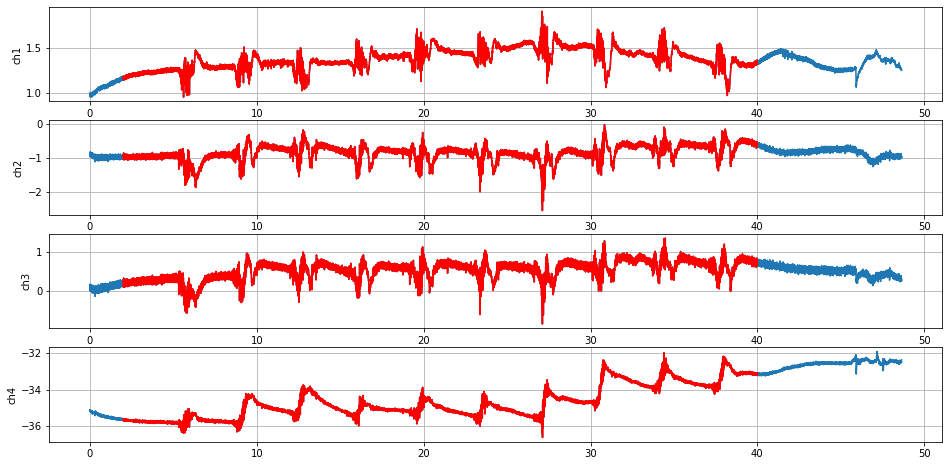

In [19]:
#cut the EMG
cut_EMG = cut_and_comp_EMG(EMG,2,40)

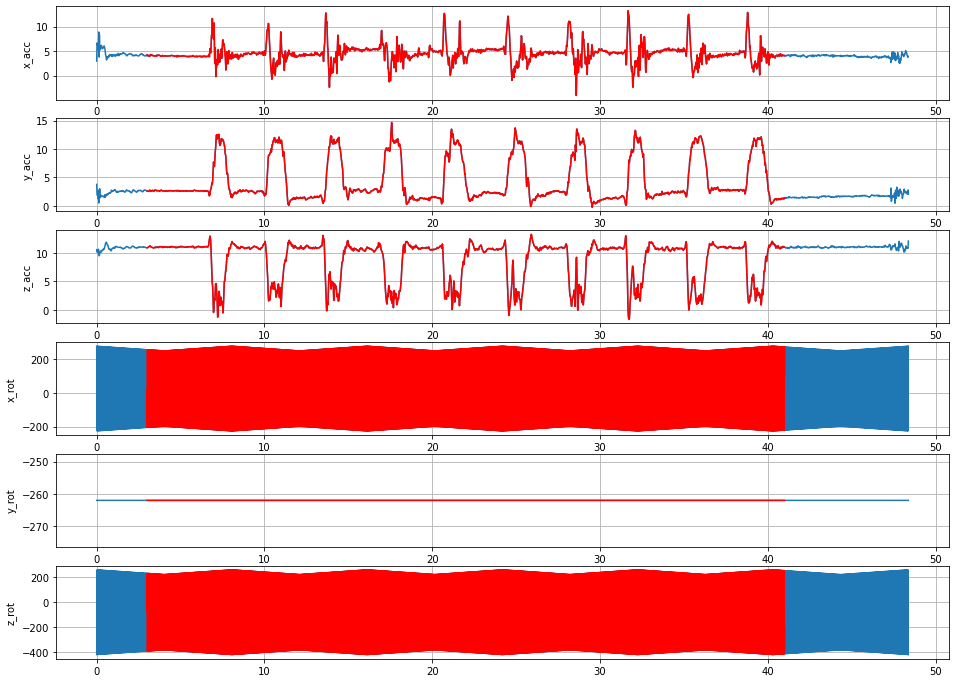

In [20]:
#cut the IMU
cut_IMU = cut_and_comp_IMU(IMU,3,41)

Text(0.5, 0, 'time in s')

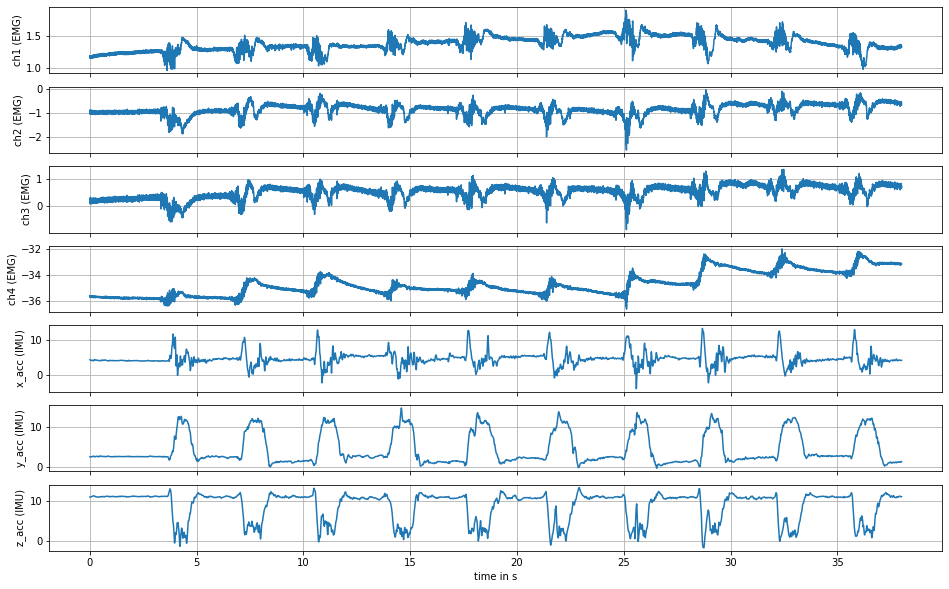

In [21]:
  
EMG_labels = cut_EMG.columns

IMU_labels = cut_IMU.columns

t_E = []
t_I = []
t0_E = cut_EMG.time[0]
t0_I = cut_IMU.time[0]

for k in range(0,len(cut_EMG.time)):
    t_E.append(cut_EMG.time[k]-t0_E)
for k in range(0,len(cut_IMU.time)):
    t_I.append(cut_IMU.time[k]-t0_I)

fig, axs = plt.subplots(7,figsize=(16,10))
axs[0].plot(t_E,cut_EMG.ch1)
axs[1].plot(t_E,cut_EMG.ch2)
axs[2].plot(t_E,cut_EMG.ch3)
axs[3].plot(t_E,cut_EMG.ch4)

axs[4].plot(t_I,cut_IMU.x_acc)       
axs[5].plot(t_I,cut_IMU.y_acc)
axs[6].plot(t_I,cut_IMU.z_acc)

for k in range(0,4):
    axs[k].set_ylabel(EMG_labels[k+1] + ' (EMG)')
    axs[k].grid()
    axs[k].set_xticklabels([])
    
for k in range(0,3):
    axs[k+4].set_ylabel(IMU_labels[k+1] + ' (IMU)')
    axs[k+4].grid()

axs[4].set_xticklabels([])
axs[5].set_xticklabels([])

axs[6].set_xlabel('time in s')

### <b> <u> 2. Find the peaks

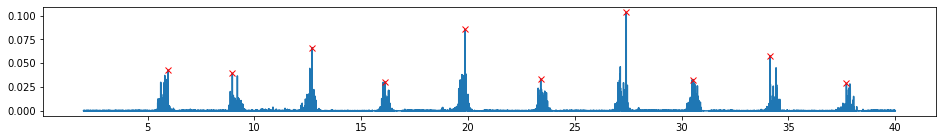

[2025, 3563, 5478, 7219, 9127, 10946, 12997, 14600, 16446, 18274]
10 EMG-peaks were identified


In [22]:
EMG_peaks = EMG_peaks_and_visualisation(cut_EMG,'ch1',fs,0.01)
print(EMG_peaks)
print(str(len(EMG_peaks)) + " EMG-peaks were identified")
#EMG_peaks.remove(EMG_peaks[len(EMG_peaks)-1])

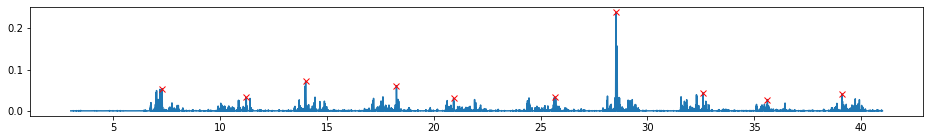

[2192, 4199, 5631, 7809, 9178, 11617, 13076, 15155, 16703, 18495]
10 IMU-peaks were identified


In [23]:
IMU_peaks = IMU_peaks_and_visualisation(cut_IMU,'y_acc',fs,0.007)
print(IMU_peaks)
print(str(len(IMU_peaks)) + " IMU-peaks were identified")
#IMU_peaks.remove(IMU_peaks[len(IMU_peaks)-1])

### <b> <u> 3. Motion segments extraction

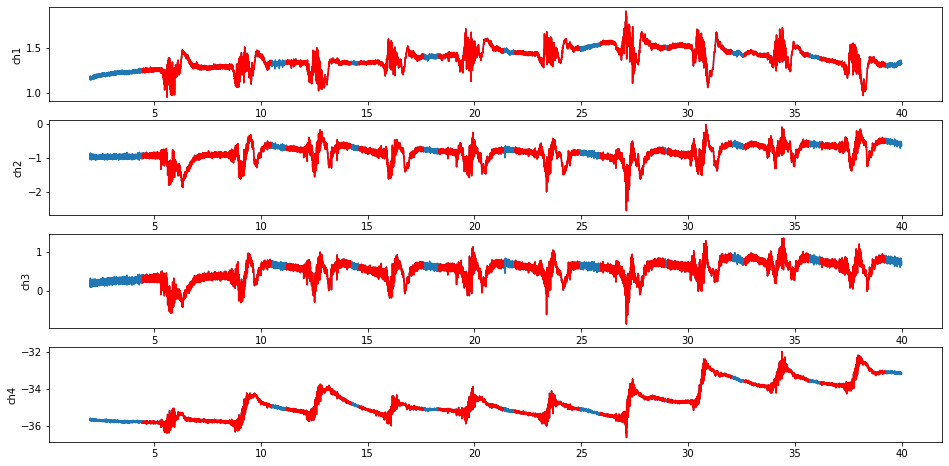

In [24]:
EMG_seg = EMG_wave_extraction(cut_EMG,EMG_peaks,fs)

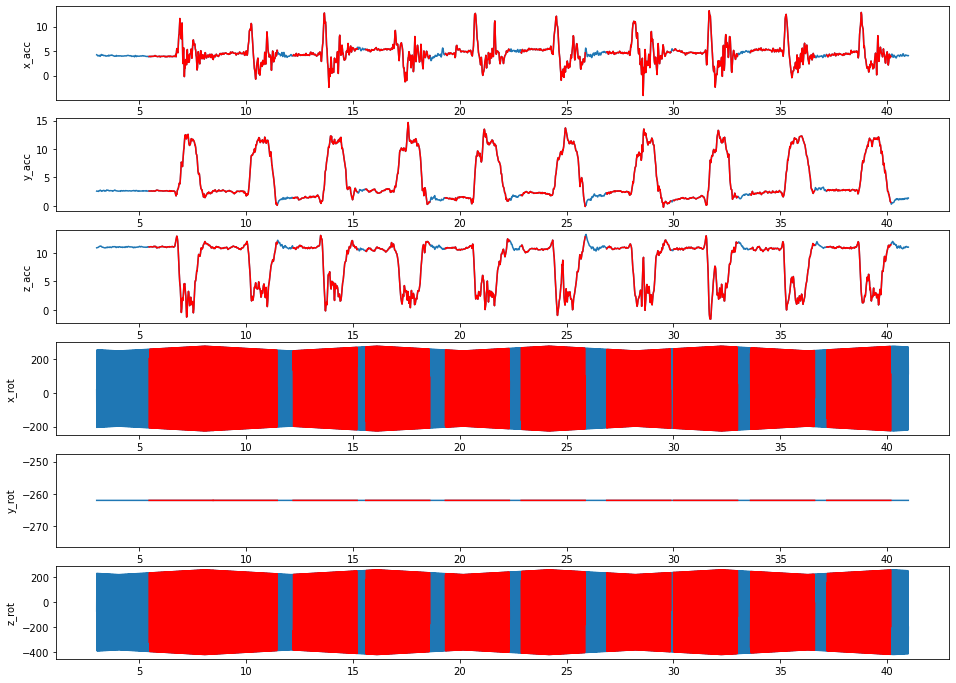

In [25]:
IMU_seg = IMU_wave_extraction(cut_IMU,EMG_peaks,fs) #change to EMG_peaks if it works better

In [26]:
print(len(IMU_seg[0]))
print(len(EMG_seg[0]))

10
10


### <b> <u> 4. Make Dataframe and save it

In [27]:
EMG_frame = EMG_wave_to_dataframe(EMG_seg,fs)
IMU_frame = IMU_wave_to_dataframe(IMU_seg,fs)

all_data = make_dataframe(EMG_seg,IMU_seg,fs)

In [28]:
all_data[0]

,time,ch1,ch2,ch3,ch4,x_acc,y_acc,z_acc,x_rot,y_rot,z_rot
0,0.000000,1.258522,-0.931523,0.326999,-35.790791,3.936381,2.611892,11.068414,204.090153,-262.015267,-318.332259
1,0.001953,1.246694,-0.968305,0.278389,-35.845603,3.937588,2.614307,11.070829,148.046053,-262.015267,-242.944244
2,0.003906,1.230539,-0.965420,0.265119,-35.771535,3.938796,2.616722,11.073244,92.001953,-262.015267,-167.556229
3,0.005859,1.226356,-1.002995,0.223361,-35.790863,3.940003,2.619137,11.075659,35.957853,-262.015267,-92.168214
4,0.007812,1.228159,-1.018430,0.209730,-35.827717,3.941211,2.621552,11.078073,-20.086248,-262.015267,-16.780199
...,...,...,...,...,...,...,...,...,...,...,...
1531,2.990234,1.277346,-0.927340,0.350006,-35.734536,3.345468,2.639868,10.944731,168.816978,-262.015267,-270.884363
1532,2.992188,1.289318,-0.897482,0.391837,-35.683907,3.344260,2.644697,10.938694,112.772878,-262.015267,-195.496348
1533,2.994141,1.289751,-0.877432,0.412319,-35.735546,3.343053,2.649527,10.932656,56.728778,-262.015267,-120.108333
1534,2.996094,1.297973,-0.873970,0.424003,-35.701288,3.341846,2.654357,10.926619,0.684678,-262.015267,-44.720318


In [29]:
#save_to_csv(all_data,subject_number,motion_number,side) #and save it as csv at right position



In [30]:
len(all_data)

10

In [31]:
len(EMG_frame)

10

In [32]:
len(IMU_frame)

10